# Прогноз рисков ДТП

## Цель

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

*В целом, задача выглядит несколько перекошенной: мы пытаемся оценить вероятность ДТП на основе статистики ДТП. Мы сразу программируем в своей моделе проф.деформацию. Ведь там все аварийные. А значит модель должна прийти к тому, что авария неизбежна. Единственное различие - будешь ты виновником или жертвой. Не хотел бы я жить в таком мире.*

## Подключение к базе данных ДТП

In [1]:
import warnings
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine
from tqdm import tqdm

In [2]:
try:
    from skorch import NeuralNetClassifier
except ImportError:
    !pip install skorch
    from skorch import NeuralNetClassifier

In [3]:
try:
    import shap
except ImportError:
    !pip install shap
    import shap

In [4]:
try:
    from imblearn.over_sampling import ADASYN, SMOTE
    from imblearn.under_sampling import ClusterCentroids
except:
    !pip install imblearn
    from imblearn.over_sampling import ADASYN, SMOTE
    from imblearn.under_sampling import ClusterCentroids

In [5]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

In [6]:
db_config = {
    "user": "praktikum_student",
    "pwd": "Sdf4$2;d-d30pp",
    "host": "rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net",
    "port": 6432,
    "db": "data-science-vehicle-db",
}

connection_string = "postgresql://{}:{}@{}:{}/{}".format(
    db_config["user"],
    db_config["pwd"],
    db_config["host"],
    db_config["port"],
    db_config["db"],
)

engine = create_engine(connection_string)

In [7]:
query = """
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND 
    schemaname != 'information_schema';
"""

pd.read_sql_query(query, con=engine)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,public,case_ids,praktikum_admin,None,True,False,True,False
1,public,collisions,praktikum_admin,None,False,False,True,False
2,public,parties,praktikum_admin,None,True,False,True,False
3,public,vehicles,praktikum_admin,None,True,False,True,False


## Первичное исследование таблиц

Мы прочитали БД и обнаружили в ней ожидаемые таблицы. Даже одну лишнюю - `case_ids`. Посмотрим, что в ней

In [8]:
pd.read_sql_query("SELECT * FROM case_ids LIMIT 10", con=engine)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [9]:
pd.read_sql_query("SELECT distinct db_year FROM case_ids", con=engine)

,db_year
0,2021


Похоже, в ней просто перечислены id происшествий и задан db_year, равный 2021, скорее всего, это год попадания записи в БД. Вряд ли эта таблица будет нам полезна.

Прочитаем остальные таблицы.

In [10]:
pd.read_sql_query("SELECT * FROM collisions LIMIT 10", con=engine)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [11]:
pd.read_sql_query("SELECT * FROM parties LIMIT 10", con=engine)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [12]:
pd.read_sql_query("SELECT * FROM vehicles LIMIT 10", con=engine)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Видно, что все наши таблицы имеют общее поле - `case_id`, которое является идентификатором происшествия. 

##  Статистический анализ факторов ДТП

Посмотрим, как аварии распределены по месяцам 

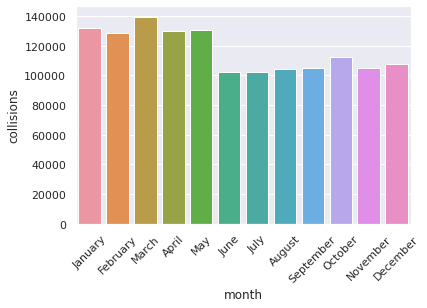

In [13]:
query = """
select  count(DISTINCT case_id) as collisions,  
extract( month from collision_date) as month
FROM collisions
group by (extract (month from collision_date));
"""

collisions_month = pd.read_sql_query(query, con=engine)

collisions_month.columns = ["collisions", "month"]

sns.set(rc={"figure.figsize": (12, 8)})

ax = sns.barplot(data=collisions_month, x="month", y="collisions").set(
    xticklabels=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
)
plt.xticks(rotation=45);

В целом, в первые 5 месяцев года происходится больше аварий, чем в оставшиеся 7. Но наиболее богат на ававрийные ситуации март. Можно предположить, что это связано с неблагоприятными погодными условиями и усложнением в связи с этим дорожной обстановки. 

In [14]:
query = """
SELECT
	DISTINCT to_char(collision_date, 'yyyy-mm') AS date,
	count(case_id)
FROM
	collisions c
WHERE
	collision_damage <> 'scratch'
GROUP BY
	to_char(collision_date, 'yyyy-mm')
ORDER BY
	date
"""
by_date = pd.read_sql_query(query, con=engine)

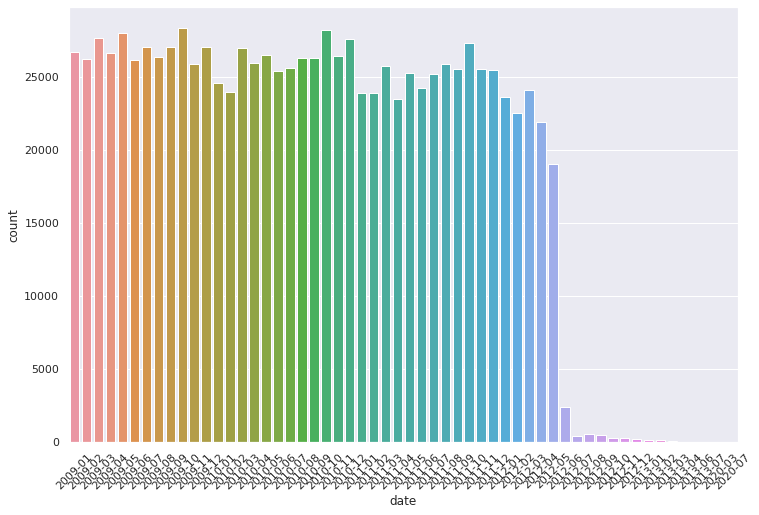

In [15]:
sns.set(rc={"figure.figsize": (12, 8)})
s = sns.barplot(data= by_date, x='date', y='count')
s.set_xticklabels(s.get_xticklabels(), rotation=45);

Кажется, что с данными что-то не то. Прежде всего, становится понятна причина более высокой аварийности в первые месяци годас января 2009 по май 2012 фиксируется довольно большое количество аварий (25$\pm$5 тысяч). Но уже в июне 2012 их в 10 раз больше, а дальше на превышает 600, в декабре 2012 их всего 200. Это ставит под сомнение результаты последующего моделирования :( ИМХО, стоило использовать хотя бы интервал май 2011 - май 2012. Но условия задания недвусмысленно постулируют интервал дат для исследования.   

На что ещё стоит обратить внимание, так это на возрас автомобилей:

In [16]:
query = """SELECT count(id), vehicle_age 
FROM vehicles v 
GROUP BY vehicle_age """
ages = pd.read_sql_query(query, con=engine)

In [17]:
ages

,count,vehicle_age
0,40262,0.0
1,41307,1.0
2,106530,2.0
3,178550,3.0
4,125472,4.0
5,105035,5.0
6,84362,6.0
7,84282,7.0
8,77070,8.0
9,58255,9.0


Видно, что 17 машин имеют возраст 161 год, что вряд ли возможно. Но какое значение возраста является правильным сказать сложно, это может быть и 16 лет. Безопаснее будет сбросить возраст в None. 

Для первого совещание рабочей группы создадим подходящие аналитические задачи:

### Задача 1

Определить серьёзность повреждений при аварии в зависимости от типа кузова. Гипотеза: люди, склонные к более рискованному вождению чаще выбирают одни типы кузова (купе, хэтчбек?), чем другие.

### Задача 2

Проанализировать серьёзность повреждений транспортного средства, исходя из физического состояния водителя в момент ДТП

### Задача 3

Определить частоту пьяных аварий в зависимости от времени суток. Гипотеза: можно предположить, что вечером и ночью подобные аварии случаются чаще.

### Задача 4

Определить вероятность серьёзной аварии при использовании телефона.

### Задача 5

Определить вероятность аварии в зависимости от состяния дороги и разговора по телефону.

### Задача 6

Определить вероятность аварии из-за того, что водитель уснул на дорогах разного типа.

Ход решения задачи 1 следующий:

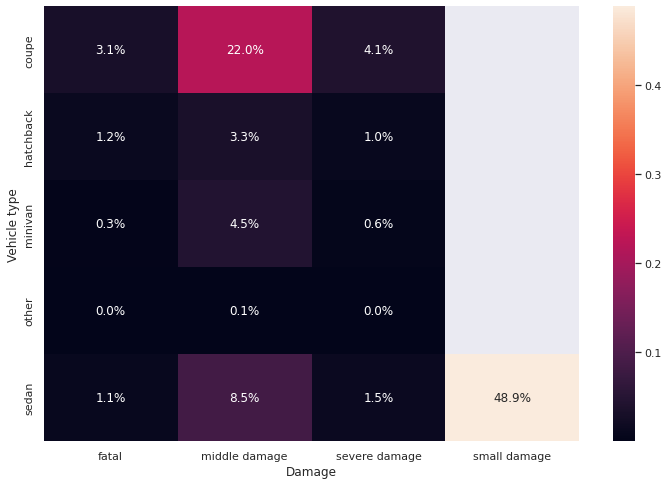

In [20]:
query = """
WITH t AS (
SELECT
	count(DISTINCT c.case_id) AS collisions,
	vehicle_type,
	collision_damage
FROM
	collisions c
JOIN vehicles v ON
	c.case_id = v.case_id
WHERE
	collision_damage <> 'scratch'
	AND EXTRACT (YEAR
FROM
	collision_date) = 2012
GROUP BY
	vehicle_type,
	collision_damage
),
s AS (
SELECT
	sum(collisions)
FROM
	t)
SELECT
	collisions * 1. / (SELECT * FROM s) AS collisions_rate,
	vehicle_type,
	collision_damage
FROM
	t
"""

collisions_type_damage = pd.read_sql_query(query, con=engine)

collisions_type_damage = collisions_type_damage.pivot(
    index="vehicle_type", columns="collision_damage", values="collisions_rate"
)

sns.set(rc={"figure.figsize": (12, 8)})
sns.heatmap(
    data=collisions_type_damage,
    annot=True,
    fmt=".1%",
).set(ylabel="Vehicle type", xlabel="Damage");

Видно, что большинство сочетаний типа кузова и повреждений очень редки или вовсе отсутствуют. Но есть два заметных выброса - это седан с маленькими поовреждениями и купе со средними повреждениями. Ситуация с седанами более-менее предсказуема: седан - самый распространённый кузов, а небольшие повреждения - самый частый исход аварии (после царапин). С купе чуть интереснее: по средним повреждениям они сильно выбиваются из общей статистики (по остальным тоже, но это не так бросается в глаза). Отсюда вывод: авто с кузовом купе достойны дополнительного исследования. Как гипотеза: люди часто арендовавшие купе более склонны к авариам.    

Теперь задача 2:

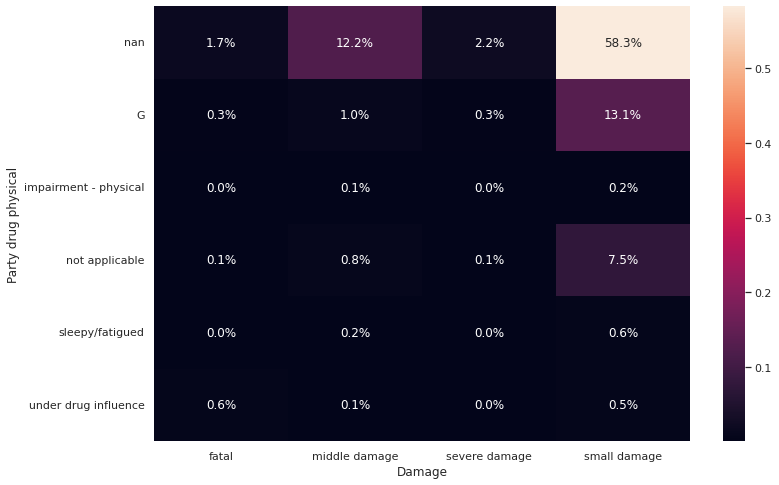

In [21]:
query = """
WITH t AS (
SELECT
	count(DISTINCT c.case_id) AS collisions,
	collision_damage,
	party_drug_physical
FROM
	collisions c
JOIN parties p ON
	c.case_id = p.case_id
WHERE
	collision_damage <> 'scratch'
	AND collision_date >= '2012-01-01'
GROUP BY
	collision_damage,
	party_drug_physical
),
s AS (
SELECT
	sum(collisions)
FROM
	t)
SELECT
	collisions * 1. / (
	SELECT
		*
	FROM
		s) AS collisions_rate,
	collision_damage,
	party_drug_physical
FROM
	t
"""

collisions_damage_drugs = pd.read_sql_query(query, con=engine)

sns.set(rc={"figure.figsize": (12, 8)})
collisions_damage_drugs = collisions_damage_drugs.pivot(
    index="party_drug_physical", columns="collision_damage", values="collisions_rate"
)

sns.heatmap(
    data=collisions_damage_drugs,
    annot=True,
    fmt=".1%",
).set(ylabel="Party drug physical", xlabel="Damage");

К сожалению, определённые выводы о корреляции вероятности аварии и физического состяния делать сложно, поскольку фактически все пиковые значения приходятся либо на NaN (не указано) или на G (не известно)   

## Создание модели для оценки водительского риска

Выгрузим из БД все инттересующие нас происшествия: события, произошедшие в 2012, приведшие, виновниками которых стал автомобилист, в том случае, когда последствия были тяжелее просто й царапины.

In [22]:
query = """
SELECT
	collision_time,
	intersection,
	weather_1,
	road_surface,
	lighting,
	location_type,
	road_condition_1,
	party_drug_physical,
	party_sobriety,
	cellphone_in_use,
	vehicle_type,
	vehicle_transmission,
	vehicle_age,
    at_fault
FROM
	collisions c
JOIN parties p ON
	p.case_id = c.case_id
JOIN vehicles v ON
	v.case_id = c.case_id
WHERE
	collision_damage <> 'scratch'
	AND collision_date >= '2012-01-01'
	AND c.case_id IN (
	SELECT
		DISTINCT case_id
	FROM
		parties
	WHERE
		at_fault = 1
		AND party_type = 'car')
"""
df = pd.read_sql_query(query, con=engine)

In [23]:
df.shape

(117559, 14)

In [24]:
df.head()

,collision_time,intersection,weather_1,road_surface,lighting,location_type,road_condition_1,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,17:42:00,0.0,clear,dry,dark with street lights,None,normal,under drug influence,"had been drinking, under influence",NaN,hatchback,manual,8.0,0
1,07:05:00,0.0,clear,dry,daylight,None,normal,None,had not been drinking,0.0,hatchback,auto,10.0,0
2,16:15:00,1.0,clear,dry,daylight,None,normal,None,had not been drinking,0.0,hatchback,auto,13.0,0
3,05:45:00,0.0,clear,dry,dusk or dawn,None,normal,None,None,NaN,sedan,auto,7.0,0
4,05:45:00,0.0,clear,dry,dusk or dawn,None,normal,None,None,NaN,sedan,auto,7.0,0


Мы отбрали наиболее перспективные признаки, которые должны влиять на вероятность ДТП: 

In [25]:
df["collision_time"] = pd.to_datetime(df["collision_time"], format="%H:%M:%S").dt.hour

In [26]:
df.loc[df["vehicle_age"] > 20, "vehicle_age"] = None

In [27]:
df.columns

Index(['collision_time', 'intersection', 'weather_1', 'road_surface',
       'lighting', 'location_type', 'road_condition_1', 'party_drug_physical',
       'party_sobriety', 'cellphone_in_use', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'at_fault'],
      dtype='object')

## Распределения аварий по интересующим нас признакам

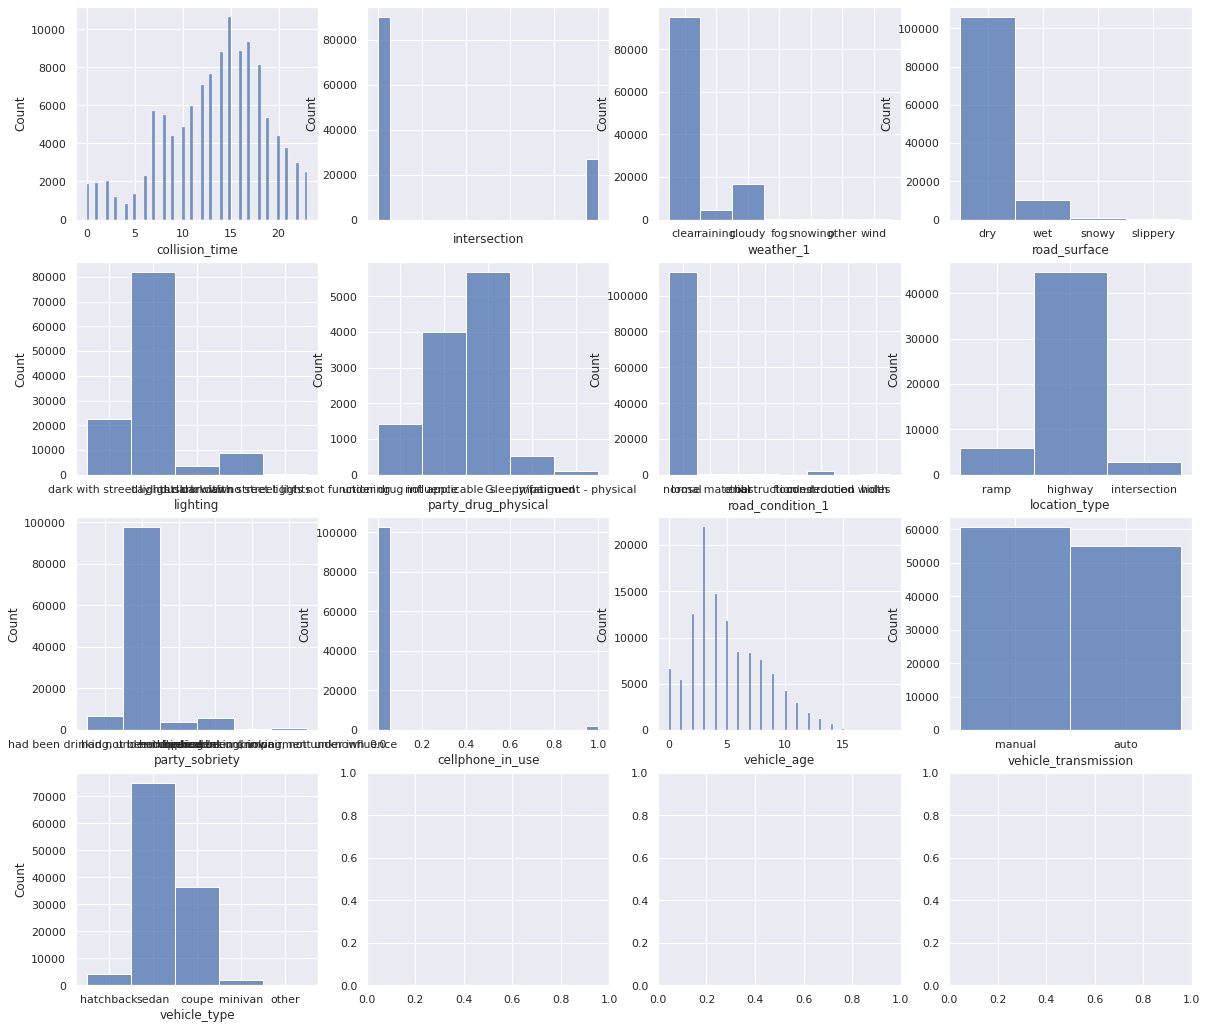

In [28]:
fig, axs = plt.subplots(4, 4, figsize=(20, 18))
sns.histplot(
    ax=axs[0][0],
    data=df,
    x="collision_time",
    palette="rocket",
)
s = sns.histplot(
    ax=axs[0][1],
    data=df,
    x="intersection",
    palette="rocket",
)
s.set_xticklabels(list(s.get_xticklabels()), rotation=45)
sns.histplot(
    ax=axs[0][2],
    data=df,
    x="weather_1",
    palette="rocket",
)
sns.histplot(
    ax=axs[0][3],
    data=df,
    x="road_surface",
    palette="rocket",
)
sns.histplot(
    ax=axs[1][0],
    data=df,
    x="lighting",
    palette="rocket",
)
s = sns.histplot(
    ax=axs[1][1],
    data=df,
    x="party_drug_physical",
    palette="rocket",
)
s = sns.histplot(
    ax=axs[1][2],
    data=df,
    x="road_condition_1",
    palette="rocket",
)
sns.histplot(
    ax=axs[1][3],
    data=df,
    x="location_type",
    palette="rocket",
)
sns.histplot(
    ax=axs[2][0],
    data=df,
    x="party_sobriety",
    palette="rocket",
)
s = sns.histplot(
    ax=axs[2][1],
    data=df,
    x="cellphone_in_use",
    palette="rocket",
)
s = sns.histplot(
    ax=axs[2][2],
    data=df,
    x="vehicle_age",
    palette="rocket",
)
sns.histplot(
    ax=axs[2][3],
    data=df,
    x="vehicle_transmission",
    palette="rocket",
)
sns.histplot(
    ax=axs[3][0],
    data=df,
    x="vehicle_type",
    palette="rocket",
);

Глядя на графики, мы можем сделать выводы о том, что ряд признаков не работают так как нам хотелось: количество ДТП с автоматической и ручной коробкой передач почти равно, практически никто из участников аварий не разговариал по телефону, практически все аварии произошли на нормальных дорогах, хотя около 20тыс. произошли на ремонтируемых дорогах. Очень мало ДТП произошло на перекрёстках: очевидно, это связано с тем, что машины проводят на перекрёстках сравнительно мало времени. Опять же основная масса ааврий произошла на сухом дорожном полотне, так что этот признак не информативен, тоже можно сказать и о погоде: большинство аварий произошло при ясной погоде. Очевидно, в Калиформии большую часть времени держится именно такая погода.

Таким образом от изначального списка признаков оставим следующие

In [29]:
features = [
    "collision_time",
    "lighting",
    "location_type",
    "party_drug_physical",
    "party_sobriety",
    "vehicle_type",
    "vehicle_age",
]

Избавимся от NaN, которые мешают всем нашим моделям:

In [30]:
df = df[features + ["at_fault"]]
df = df.dropna()

In [31]:
df.shape

(3366, 8)

In [32]:
X = df[features]
y = df["at_fault"]

In [33]:
y.mean()

0.6788472964943553

In [34]:
df["at_fault"].value_counts()

1    2285
0    1081
Name: at_fault, dtype: int64

Классы у нас не очень сбалансированы, так что это может стать проблемой. Чтобы этого избежать, потребуется баллансировка.

Прежде чем браться за обучение моделей, нужно подготовить данные: масштабировать время аварии и возраст авто, преобразовать в числа остальные категориальные признаки. Мы планируем использовать модели решающего дерева, градиентного бустинга и нейросети, поэтому преобразовывать категориальные признаки придётся двумя способами: деревья не очень хорошо работают OHE-преобразованиями, для него используем LabelEncoder.  

In [35]:
ohe = make_column_transformer(
    (
        OneHotEncoder(sparse=False, drop="first"),
        [
            "lighting",
            "location_type",
            "party_drug_physical",
            "party_sobriety",
            "vehicle_type",
        ],
    ),
    remainder="passthrough",
)
X_ohe = pd.DataFrame(ohe.fit_transform(X), columns=ohe.get_feature_names())

In [36]:
X_ohe.head()

,onehotencoder__x0_dark with street lights,onehotencoder__x0_dark with street lights not functioning,onehotencoder__x0_daylight,onehotencoder__x0_dusk or dawn,onehotencoder__x1_intersection,onehotencoder__x1_ramp,onehotencoder__x2_impairment - physical,onehotencoder__x2_not applicable,onehotencoder__x2_sleepy/fatigued,onehotencoder__x2_under drug influence,"onehotencoder__x3_had been drinking, not under influence","onehotencoder__x3_had been drinking, under influence",onehotencoder__x3_had not been drinking,onehotencoder__x3_impairment unknown,onehotencoder__x3_not applicable,onehotencoder__x4_hatchback,onehotencoder__x4_minivan,onehotencoder__x4_other,onehotencoder__x4_sedan,collision_time,vehicle_age
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,9.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,9.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,9.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,9.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0


Получившиеся названия колонк как минимум уродливы и не очень информативны. Исправим их:

In [37]:
columns = []
for c in X_ohe.columns:
    if c.startswith("onehotencoder__x0"):
        c = "lightning" + c[17:]
    elif c.startswith("onehotencoder__x1"):
        c = "location_type" + c[17:]
    elif c.startswith("onehotencoder__x2"):
        c = "party_drug_physical" + c[17:]
    elif c.startswith("onehotencoder__x3"):
        c = "party_sobriety" + c[17:]
    elif c.startswith("onehotencoder__x4"):
        c = "vehicle_type" + c[17:]
    c = c.replace(" ", "_").replace("/", "_").replace(",", "")
    columns.append(c)
X_ohe.columns = columns

In [38]:
X_lbl = X.copy()
for c in [
    "lighting",
    "location_type",
    "party_drug_physical",
    "party_sobriety",
    "vehicle_type",
]:
    X_lbl[c] = LabelEncoder().fit_transform(X_lbl[c])

In [39]:
X_ohe_train, X_ohe_valid, y_ohe_train, y_ohe_valid = train_test_split(
    X_ohe, y, random_state=42
)

Для работы решающего дерева нужно избавиться от NaN

In [40]:
X_lbl = X_lbl.dropna()
y_lbl = y.loc[X_lbl.index]

In [41]:
X_lbl_train, X_lbl_valid, y_lbl_train, y_lbl_valid = train_test_split(
    X_lbl, y_lbl, random_state=42
)

In [42]:
scaler = StandardScaler()

columns = ["collision_time", "vehicle_age"]
X_ohe_train[columns] = scaler.fit_transform(X_ohe_train[columns])
X_ohe_valid[columns] = scaler.transform(X_ohe_valid[columns])
X_lbl_train[columns] = scaler.fit_transform(X_lbl_train[columns])
X_lbl_valid[columns] = scaler.transform(X_lbl_valid[columns])

In [43]:
X_ohe_train

,lightning_dark_with_street_lights,lightning_dark_with_street_lights_not_functioning,lightning_daylight,lightning_dusk_or_dawn,location_type_intersection,location_type_ramp,party_drug_physical_impairment_-_physical,party_drug_physical_not_applicable,party_drug_physical_sleepy_fatigued,party_drug_physical_under_drug_influence,party_sobriety_had_been_drinking_not_under_influence,party_sobriety_had_been_drinking_under_influence,party_sobriety_had_not_been_drinking,party_sobriety_impairment_unknown,party_sobriety_not_applicable,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,collision_time,vehicle_age
1286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.65,-1.41e+00
521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.11,3.49e-01
522,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.11,-7.05e-01
1922,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.70,-3.54e-01
847,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.26,-1.41e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,-7.05e-01
1130,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.25,1.05e+00
1294,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.16,-2.78e-03
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.16,3.49e-01


## Обучение моделей

В качестве меры точности кажется уместным использовать recall: этот показатель тем больше, чем больше положительных событий мы сможем предскказать. Это согласуется с постановкой задачи: заказчик хочет обезопасить поездки и, следовательно, максимально выявлять потенциально рискованные ситуации. Лишние рекомендации в начале поездки условно бесплатны. Если частые срабатывания будут вызывать у водителей негатив, в дальнейшем можно будет заменить меру на более адекватную.

### Решающее дерево

Начнём со сравнительно модели - решающего дерева. Прежде всего надо сбалансировать классы исходов.  Вариантов два: oversampling, добавляющий недостающих отрицательных исходов и undersampling, отбрасывающий избыточные положительные исходы. 

Обычно лучше работает oversapling, но стоит проверить. Экспериментировать будем на дереве с дефолтными параметрами

In [45]:
X_lbl_over, y_lbl_over = ADASYN().fit_resample(X_lbl_train, y_lbl_train)
y_lbl_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: at_fault, dtype: float64

In [46]:
dt = DecisionTreeClassifier(random_state=42).fit(X_lbl_over, y_lbl_over)
print(f"Recall: {recall_score(y_lbl_valid, dt.predict(X_lbl_valid))}")

Recall: 0.7321428571428571


In [47]:
X_lbl_under, y_lbl_under = ClusterCentroids(random_state=42).fit_resample(
    X_lbl_train, y_lbl_train
)

y_lbl_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: at_fault, dtype: float64

In [48]:
dt = DecisionTreeClassifier(random_state=42).fit(X_lbl_under, y_lbl_under)
print(f"Recall: {recall_score(y_lbl_valid, dt.predict(X_lbl_valid))}")

Recall: 0.4767857142857143


Как видно, oversampling работает ощутимо лучше и уже при настройках по умолчанию, дерево правильно предсказывает почти 3/4 целевых событий. Займёмся тюнингом. Увы, при оверсемплинге мы не можем использовать привычную кросс-валидацию, так что придётся выкручиваться иначе.

In [49]:
scorer = make_scorer(recall_score)

In [50]:
%%time

dt = DecisionTreeClassifier(random_state=42)
best_score = 0
best_dt = None

for prm in ParameterGrid(
    {
        "max_depth": range(4, 20 + 1, 2),
        "min_samples_split": range(2, 6 + 1, 1),
        "min_samples_leaf": range(6, 16 + 1, 2),
    }
):
    dt.set_params(**prm).fit(X_lbl_over, y_lbl_over)
    score = recall_score(y_lbl_valid, dt.predict(X_lbl_valid))
    if best_score < score:
        best_score = score
        best_dt = deepcopy(dt)

CPU times: user 1.81 s, sys: 1.88 ms, total: 1.81 s
Wall time: 1.81 s


In [51]:
best_dt

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, random_state=42)

In [52]:
best_score

0.9928571428571429

In [53]:
print(f"Precision: {precision_score(y_lbl_valid, best_dt.predict(X_lbl_valid))}")

Precision: 0.8011527377521613


Даже у такой простой модели как решающее дерево recall приблизился к 100%. На удивление и precision достаточно велико и даже чуть выше recall. В практической ситуации дальше можно было бы и не продолжать: предельно простая и лёгкая модель даёт отличные результаты, и городить огород вряд ли нужно. 

Но у нас задачи другие

### Градиентный бустинг

Повторим упражнение с oversampling и undersampling:

In [54]:
X_ohe_over, y_ohe_over = ADASYN().fit_resample(X_ohe_train, y_ohe_train)
y_ohe_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: at_fault, dtype: float64

In [55]:
X_ohe_under, y_ohe_under = ClusterCentroids(random_state=42).fit_resample(
    X_ohe_train, y_ohe_train
)
y_ohe_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: at_fault, dtype: float64

In [56]:
gb = GradientBoostingClassifier(random_state=42).fit(X_ohe_over, y_ohe_over)
print(f"Recall: {recall_score(y_ohe_valid, gb.predict(X_ohe_valid))}")

Recall: 0.9410714285714286


In [57]:
gb = GradientBoostingClassifier(random_state=42).fit(X_ohe_under, y_ohe_under)
print(f"Recall: {recall_score(y_ohe_valid, gb.predict(X_ohe_valid))}")

Recall: 0.5553571428571429


И в случае градиентного бустинга oversampling даёт заметно лучший результат

In [58]:
%%time

gb = GradientBoostingClassifier(random_state=42)
best_score = 0
best_gb = None

for prm in ParameterGrid(
    {
        "learning_rate": [0.1, 0.05, 0.01],
        "n_estimators": [100, 250, 500],
        "max_depth": [15, 20, 25],
    }
):
    gb.set_params(**prm).fit(X_ohe_over, y_ohe_over)
    score = recall_score(y_ohe_valid, gb.predict(X_ohe_valid))
    if best_score < score:
        best_score = score
        best_gb = deepcopy(gb)

CPU times: user 2min 54s, sys: 151 ms, total: 2min 55s
Wall time: 2min 55s


In [59]:
print(f"Recall: {best_score:.4f}")

Recall: 0.8464


In [60]:
print(f"Precision: {precision_score(y_ohe_valid, best_gb.predict(X_ohe_valid)):.4f}")

Precision: 0.7966


Градиентный бустинг чуть обошёл дерево по метрике recall, хотя и показал гораздо худшую производительность: 3 минуты против 1,6 секунды. Precision оказалась также на приличном уровне и выше значения recall. 

### Нейронная сеть

Преобразуем датафреймы в тензоры:

In [61]:
X_train_over = torch.FloatTensor(X_ohe_over.values)
X_train_under = torch.FloatTensor(X_ohe_under.values)
y_train_over = torch.FloatTensor(y_ohe_over.values)
y_train_under = torch.FloatTensor(y_ohe_under.values)
X_valid = torch.FloatTensor(X_ohe_valid.values)
y_valid = torch.FloatTensor(y_ohe_valid.values)

In [62]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode="fan_in", nonlinearity="relu")
        nn.init.normal_(layer.bias, 1, 5)

In [63]:
num_features = X_ohe_over.shape[1]
n_out_neurons = 1


class Net(nn.Module):
    def __init__(
        self,
        n_hidden_neurons_1=num_features,
        n_hidden_neurons_2=num_features // 2,
        p1=0,
        p2=0,
    ):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, n_hidden_neurons_1),
            nn.Dropout(p1) if p1 > 0 and p1 < 1 else nn.Identity(),
            nn.Tanh(),
            nn.Dropout(p2) if p2 > 0 and p2 < 1 else nn.Identity(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.Tanh(),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [64]:
%%time

net = Net(int(num_features * 1.5), num_features // 2, 0, 0)
net.layers.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
num_epochs = 2000
best_net = None
best_epoch = -1
best_loss = 1e10

errors = pd.DataFrame(columns=["train", "valid"])

with tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()

        preds = net(X_train_over).flatten()

        loss = criterion(preds, y_train_over)
        loss.backward()

        optimizer.step()

        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval()
            valid_preds = net(X_valid).flatten()
            loss_valid = criterion(valid_preds, y_valid)
            errors.at[epoch, "train"] = loss.item()
            errors.at[epoch, "valid"] = loss_valid.item()
            recall = recall_score(
                y_valid.detach().numpy().astype(int),
                np.around(valid_preds.detach().numpy()).astype(int),
            )
            if loss_valid < best_loss:
                best_loss = loss_valid
                best_epoch = epoch
                best_net = deepcopy(net)

        pbar.set_description(f"Loss: {loss.item():.4f}; Recall: {recall:.4f}")
        pbar.update(1)

Loss: 0.5036; Recall: 0.7857: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 259.84it/s]

CPU times: user 45 s, sys: 522 ms, total: 45.5 s
Wall time: 7.72 s


In [65]:
preds = best_net(X_valid).flatten()
print(
    f"Recall: {recall_score(y_valid.detach().numpy().astype(int), np.around(preds.detach().numpy()).astype(int))}"
)
print(
    f"Precision: {precision_score(y_valid.detach().numpy().astype(int), np.around(preds.detach().numpy()).astype(int))}"
)

Recall: 0.7571428571428571
Precision: 0.8330058939096268


In [66]:
%%time

net = Net(int(num_features * 1.5), num_features // 2, 0, 0)
net.layers.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
num_epochs = 2000
best_net = None
best_epoch = -1
best_loss = 1e10

errors = pd.DataFrame(columns=["train", "valid"])

with tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()

        preds = net(X_train_under).flatten()

        loss = criterion(preds, y_train_under)
        loss.backward()

        optimizer.step()

        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval()
            valid_preds = net(X_valid).flatten()
            loss_valid = criterion(valid_preds, y_valid)
            errors.at[epoch, "train"] = loss.item()
            errors.at[epoch, "valid"] = loss_valid.item()
            recall = recall_score(
                y_valid.detach().numpy().astype(int),
                np.around(valid_preds.detach().numpy()).astype(int),
            )
            if loss_valid < best_loss:
                best_loss = loss_valid
                best_epoch = epoch
                best_net = deepcopy(net)

        pbar.set_description(f"Loss: {loss.item():.4f}; Recall: {recall:.4f}")
        pbar.update(1)

Loss: 0.3846; Recall: 0.5071: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 347.00it/s]

CPU times: user 34.1 s, sys: 519 ms, total: 34.6 s
Wall time: 5.78 s


In [67]:
preds = best_net(X_valid).flatten()
print(
    f"Recall: {recall_score(y_valid.detach().numpy().astype(int), np.around(preds.detach().numpy()).astype(int))}"
)
print(
    f"Precision: {precision_score(y_valid.detach().numpy().astype(int), np.around(preds.detach().numpy()).astype(int))}"
)

Recall: 0.5464285714285714
Precision: 0.8523676880222841


И снова undersampling оказался немного, но хуже oversampling

Попробует подобрать для сети более оптимальные гиперпараметры. Для начала напишем параметризованную функцию обучения: 

In [68]:
def train_net(epochs, lr, n1, n2, p1, p2, valid_step=10):
    net = Net(n1, n2, p1, p2)
    net.layers.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_net = None
    best_epoch = -1
    best_loss = 1e10

    #     with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        net.train()
        optimizer.zero_grad()

        preds = net(X_train_over).flatten()

        loss = criterion(preds, y_train_over)
        loss.backward()

        optimizer.step()

        if epoch % valid_step == 0 or epoch == epochs - 1:
            net.eval()
            valid_preds = net(X_valid).flatten()
            loss_valid = criterion(valid_preds, y_valid)
            if loss_valid < best_loss:
                best_loss = loss_valid
                best_epoch = epoch
                best_net = deepcopy(net)

    #             pbar.set_description(f"Loss: {loss.item():.4f}; Recall: {recall_valid:.4f}")
    #             pbar.update(1)
    return (best_net, best_epoch)

In [69]:
class ReadyException(Exception):
    pass

In [70]:
%%time

opt = pd.DataFrame(columns=["n1", "n2", "p1", "p2", "best_epoch", "recall"])
try:
    for n1 in [15, 25, 50]:
        for n2 in [5, 15, 25]:
            for p1 in [0, 0.25, 0.5, 0.75]:
                for p2 in [0, 0.25, 0.5, 0.75]:
                    (best_net, best_epoch) = train_net(200, 0.005, n1, n2, p1, p2)
                    preds = best_net(X_valid)
                    recall = recall_score(
                        y_valid.detach().numpy().astype(int),
                        np.around(preds.detach().numpy()).astype(int),
                    )
                    opt = opt.append(
                        {
                            "n1": n1,
                            "n2": n2,
                            "p1": p1,
                            "p2": p2,
                            "best_epoch": best_epoch,
                            "recall": recall,
                        },
                        ignore_index=True,
                    )
                    print(
                        {
                            "n1": n1,
                            "n2": n2,
                            "p1": p1,
                            "p2": p2,
                            "best_epoch": best_epoch,
                            "recall": recall,
                        }
                    )
                    if recall > 0.99:
                        raise ReadyException
except ReadyException:
    pass

{'n1': 15, 'n2': 5, 'p1': 0, 'p2': 0, 'best_epoch': 170, 'recall': 0.7714285714285715}
{'n1': 15, 'n2': 5, 'p1': 0, 'p2': 0.25, 'best_epoch': 199, 'recall': 0.9892857142857143}
{'n1': 15, 'n2': 5, 'p1': 0, 'p2': 0.5, 'best_epoch': 199, 'recall': 0.0}
{'n1': 15, 'n2': 5, 'p1': 0, 'p2': 0.75, 'best_epoch': 50, 'recall': 1.0}
CPU times: user 10.8 s, sys: 91.6 ms, total: 10.9 s
Wall time: 2.05 s


In [71]:
print(f"Best epoch: {best_epoch}")
preds = best_net(X_valid)
print(
    f"Recall: {recall_score(y_valid.detach().numpy().astype(int),np.around(preds.detach().numpy()).astype(int))}"
)
print(
    f"Precission: {precision_score(y_valid.detach().numpy().astype(int),np.around(preds.detach().numpy()).astype(int))}"
)

Best epoch: 50
Recall: 1.0
Precission: 0.665083135391924


Итак, мы получили модель с очень высоким значением recall, но  precission, на этот раз, оказался заметно меньше, чем чем у предыдущих моделей. Если заказчика устроит на пилотном этапе, что наша модель практически полностью покрывает потенциально опасные случае, но захватывает и часть безопасных, то можно начинать пилот.

## Анализ важности факторов ДТП

In [72]:
dt_features = pd.Series(
    dict(
        zip(
            best_dt.feature_names_in_,
            best_dt.feature_importances_,
        )
    )
)
pd.options.display.float_format = "{:,.2%}".format
dt_features.sort_values(ascending=False)

party_sobriety        80.60%
collision_time        13.86%
vehicle_type           4.58%
location_type          0.66%
lighting               0.25%
vehicle_age            0.05%
party_drug_physical    0.00%
dtype: float64

Решающее дерево с большим отрывом считает наиболее значимыми факторами ДТП состояние алкогольного или наркотического опьянения.

In [73]:
gb_features = pd.Series(
    dict(
        zip(
            best_gb.feature_names_in_,
            best_gb.feature_importances_,
        )
    )
)
pd.options.display.float_format = "{:,.2%}".format
gb_features.sort_values(ascending=False)

collision_time                                         23.75%
vehicle_age                                            20.77%
party_sobriety_not_applicable                          13.00%
party_drug_physical_not_applicable                     11.14%
party_drug_physical_sleepy_fatigued                     7.47%
location_type_ramp                                      4.85%
location_type_intersection                              3.66%
vehicle_type_hatchback                                  3.28%
party_sobriety_had_been_drinking_under_influence        2.79%
vehicle_type_sedan                                      2.57%
lightning_dark_with_street_lights                       1.67%
party_sobriety_had_not_been_drinking                    1.56%
lightning_dusk_or_dawn                                  1.35%
party_sobriety_impairment_unknown                       0.73%
party_drug_physical_under_drug_influence                0.59%
lightning_daylight                                      0.41%
vehicle_

In [75]:
explainer = shap.DeepExplainer(best_net, X_train_over)

In [76]:
%%time

shap_values = explainer.shap_values(X_valid);

CPU times: user 6min 28s, sys: 396 ms, total: 6min 28s
Wall time: 5min 18s


*Для моделирования включения и отключения слоёв Dropuot использовалось их замещение слоями-пустышками (Identity), которые не поддерживаются модулем shap. В целом всё работает, но в вывод высыпается куча противных и бессмысленных предупреждений.*

In [77]:
df = pd.DataFrame(
    {
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
        "stdev_abs_shap": np.std(np.abs(shap_values), axis=0),
        "name": X_ohe_train.columns,
    }
)

In [78]:
df.sort_values("mean_abs_shap", ascending=False)[:10]

,mean_abs_shap,stdev_abs_shap,name
13,0.01%,0.01%,party_sobriety_impairment_unknown
18,0.01%,0.00%,vehicle_type_sedan
8,0.00%,0.01%,party_drug_physical_sleepy_fatigued
19,0.00%,0.00%,collision_time
0,0.00%,0.00%,lightning_dark_with_street_lights
20,0.00%,0.00%,vehicle_age
9,0.00%,0.00%,party_drug_physical_under_drug_influence
12,0.00%,0.00%,party_sobriety_had_not_been_drinking
2,0.00%,0.00%,lightning_daylight
7,0.00%,0.00%,party_drug_physical_not_applicable


И нейросеть согласна с тем, что состояние алкогольного опьянения и злоупотребление веществами оказывают наибольшее влияние на аварийность поездок.

## Выводы

Мы провели прогнозирование аварийных ситуаций на трёх разных моделях. Точность была разной, но во всех случаях достаточно высокой (80%+). И все модели сошлись на том, что наиболее значимыми признаками являются `party_sobriety_not_applicable` и `party_drug_physical_not_applicable`.

Отсюда напрашивается необходимость проверять состояние водителя перед тем как дать ему право на управление автомобилем. С одной стороны, алкогольное опьянение можно определить с помощью привычной "дудки" с конторолем по видеокамере, но это будет лишь частичное решшение проблемы: проблем с водителями под веществами это не решит.

Как вариант, можно попробовать простые тесты на реакции: главная проблема любого объянения и связанных с ним аварий в замедлении реакций. Но это тема для отдельного исследования как по физиологии (подбор наиболее простых и действенных процедур для выявления нежелательных состояний), так и в области психологии (чтобы не вызвать ненависть к сервису).